## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import scipy
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash

In [4]:
# cap is defined in an ipython magic command
try:
    print(cap)
except NameError:
    pass

Author: Tyler Spears

Last updated: 2023-09-11T12:02:02.764092-04:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.4.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-46-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: f4626e9762d57b11b85ade49e0340729eb31446f

matplotlib: 3.5.2
seaborn   : 0.12.2
skimage   : 0.19.3
sys       : 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
pitn      : 0.0.post1.dev291+ge9e5f58.d20230531
scipy     : 1.9.3
einops    : 0.6.0
numpy     : 1.23.4
nibabel   : 5.1.0
pandas    : 1.5.2




## Data Loading

In [5]:
subj_dir = Path("/data/srv/outputs/pitn/vcu/preproc")
assert subj_dir.exists()

subj_list = (
    "P_01",
    "P_02",
    "P_03",
    "P_04",
    "P_05",
    "P_06",
    "P_07",
    "P_08",
    "P_10",
    "P_11",
    "P_13",
    "P_14",
    # "P_16",
    "P_19",
    "P_20",
    "P_21",
    "P_22",
    "P_23",
    "P_24",
    "P_25",
    "P_26",
    "P_27",
    "P_29",
    "P_32",
    "P_33",
    "P_34",
    "P_37",
    "HC_01",
    "HC_02",
    "HC_03",
    "HC_04",
    "HC_05",
)

decel_subjs = {"P_03", "P_20", "P_21", "P_25", "P_29"}
control_subjs = {
    "HC_01",
    "HC_02",
    "HC_03",
    "HC_04",
    "HC_05",
}

In [6]:
# Locate primary subject files and directories.
subj_data = Box(default_box=True)

for subj_id in subj_list:
    subj_dict = Box(default_box=True)
    d = subj_dir / subj_id
    assert d.exists()

    d_diff = subj_dict.files.diffusion
    d_diff.dwi = d / "diffusion" / f"{subj_id}_dwi.nii.gz"
    d_diff.lesion_mask = d / "diffusion" / "ms_lesion_mask.nii.gz"
    d_diff.mask = d / "diffusion" / "dwi_mask.nii.gz"
    d_diff.wm_mask = (
        d
        / "diffusion"
        / "freesurfer_segmentations_reg-dwi"
        / "mrtrix_5tt/roi_masks"
        / "white_matter.nii.gz"
    )

    param_maps = d_diff.param_maps
    for p in (d / "diffusion" / "parameter_maps").glob("*"):
        p_group_name = p.name
        for im in p.glob("*.nii.gz"):
            im_name = im.name.replace("".join(im.suffixes), "")
            if "model_fit" in im_name:
                continue
            param_maps[p_group_name][im_name] = im

    d_diff.param_maps = param_maps

    subj_dict.files.diffusion = d_diff

    subj_data[subj_id] = subj_dict

In [7]:
# Locate ROI masks.
cst_roi_root_dir = subj_dir.parent / "tractography"
cst_roi_child_f = "CST/CST_aligned_roi_mask.nii.gz"

for subj_id in subj_data.keys():
    cst_roi_f = cst_roi_root_dir / subj_id / cst_roi_child_f
    assert cst_roi_f.exists()
    subj_data[subj_id].files.roi.cst = cst_roi_f

In [8]:
voxel_vol_mm3 = 1.875 * 1.875 * 2
voxel_vol_cm3 = 0.1875 * 0.1875 * 0.2

## Whole-Brain Statistics

In [9]:
data_table = {
    "subj_id": list(),
    "subj_group": list(),
    "param_group": list(),
    "metric_name": list(),
    "tissue_type": list(),
    "param_mean": list(),
    "param_median": list(),
    "param_std": list(),
}
stats_table = {
    "subj_id": list(),
    "subj_group": list(),
    "param_group": list(),
    "metric_name": list(),
    "stat_name": list(),
    "stat_value": list(),
    "dof": list(),
}
# voxel_vol_mm3 = 1.875 * 1.875 * 2
# voxel_vol_cm3 = 0.1875 * 0.1875 * 0.2
for subj_id in subj_list:
    print(subj_id)
    d = subj_data[subj_id]
    lesion_mask = nib.load(d.files.diffusion.lesion_mask).get_fdata().astype(bool)
    wm_mask = nib.load(d.files.diffusion.wm_mask).get_fdata().astype(bool)
    wm_mask = wm_mask * (~lesion_mask)

    for g, p in d.files.diffusion.param_maps.items():
        for p_name, p_f in p.items():
            p_im = nib.load(p_f).get_fdata().astype(np.float32)
            # Ignore multi-dimensional parameters for now.
            if len(p_im.shape) == 4:
                continue
            for l, a in zip(("nawm", "lesion"), (p_im[wm_mask], p_im[lesion_mask])):
                # Control subjs have an empty lesion mask.
                if l == "lesion" and subj_id in control_subjs:
                    continue
                data_table["subj_id"].append(subj_id)
                if subj_id in decel_subjs:
                    data_table["subj_group"].append("decel")
                elif subj_id in control_subjs:
                    data_table["subj_group"].append("healthy-control")
                else:
                    data_table["subj_group"].append("non-decel")
                data_table["param_group"].append(g)
                data_table["metric_name"].append(p_name)
                data_table["tissue_type"].append(l)
                a = a[~np.isnan(a)]
                data_table["param_mean"].append(a.mean())
                data_table["param_median"].append(np.median(a))
                data_table["param_std"].append(a.std())
                if np.isnan(data_table["param_mean"][-1]).any() or np.isnan(
                    data_table["param_std"][-1].any()
                ):
                    print(g, p_name, l, "has NaN")
                    print(np.isnan(a).sum(), "/", np.prod(a.shape))

            # t-statistic calculation
            # Healthy controls have no lesion vox, so the stat. comparison between nawm
            # and lesion values is invalid.
            if subj_id in control_subjs:
                continue
            wm_vox = p_im[wm_mask]
            lesion_vox = p_im[lesion_mask]
            x_bar_wm = wm_vox.mean()
            x_bar_lesion = lesion_vox.mean()
            var_bar_wm = np.var(wm_vox, ddof=1)
            var_bar_lesion = np.var(lesion_vox, ddof=1)
            n_wm = wm_vox.shape[0]
            n_lesion = lesion_vox.shape[0]
            t = x_bar_wm - x_bar_lesion / (
                np.sqrt(
                    var_bar_wm / wm_vox.shape[0] + var_bar_lesion / lesion_vox.shape[0]
                )
            )
            dof = ((var_bar_wm / n_wm + var_bar_lesion / n_lesion) ** 2) / (
                (var_bar_wm / n_wm) ** 2 / (n_wm - 1)
                + (var_bar_lesion / n_lesion) ** 2 / (n_lesion - 1)
            )

            stats_table["subj_id"].append(subj_id)
            if subj_id in decel_subjs:
                stats_table["subj_group"].append("decel")
            elif subj_id in control_subjs:
                stats_table["subj_group"].append("healthy-control")
            else:
                stats_table["subj_group"].append("non-decel")
            stats_table["param_group"].append(g)
            stats_table["metric_name"].append(p_name)
            stats_table["stat_name"].append("Welchs_t_stat")
            stats_table["stat_value"].append(t)
            stats_table["dof"].append(dof)

    lesion_vol = lesion_mask.sum() * voxel_vol_cm3
    wm_vol = wm_mask.sum() * voxel_vol_cm3
    for l, a in zip(("nawm", "lesion"), (wm_vol, lesion_vol)):
        # Control subjs have an empty lesion mask.
        if l == "lesion" and subj_id in control_subjs:
            continue
        data_table["subj_id"].append(subj_id)
        if subj_id in decel_subjs:
            data_table["subj_group"].append("decel")
        elif subj_id in control_subjs:
            data_table["subj_group"].append("healthy-control")
        else:
            data_table["subj_group"].append("non-decel")
        data_table["param_group"].append("shape")
        data_table["metric_name"].append("volume cm^3")
        data_table["tissue_type"].append(l)
        data_table["param_mean"].append(a)
        data_table["param_median"].append(a)
        data_table["param_std"].append(0)

data_table_bak = pd.DataFrame.from_dict(data_table)
data_table = data_table_bak.copy(deep=True)

# Rename some of the crazier names.
data_table.loc[
    data_table.metric_name == "wm-Watson-bundle_odi",
    "metric_name",
] = "odi"
data_table.loc[
    data_table.metric_name == "partial_volume_fraction_wm-intra-cellular-Watson-bundle",
    "metric_name",
] = "pvf_ic"
data_table.loc[
    data_table.metric_name == "partial_volume_fraction_csf-isotropic-ball",
    "metric_name",
] = "pvf_iso"
data_table.loc[
    data_table.metric_name
    == "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle",
    "metric_name",
] = "pvf_ic-stick"

stats_table_bak = pd.DataFrame.from_dict(stats_table)
stats_table = stats_table_bak.copy(deep=True)

stats_table.loc[
    stats_table.metric_name == "wm-Watson-bundle_odi",
    "metric_name",
] = "odi"
stats_table.loc[
    stats_table.metric_name
    == "partial_volume_fraction_wm-intra-cellular-Watson-bundle",
    "metric_name",
] = "pvf_ic"
stats_table.loc[
    stats_table.metric_name == "partial_volume_fraction_csf-isotropic-ball",
    "metric_name",
] = "pvf_iso"
stats_table.loc[
    stats_table.metric_name
    == "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle",
    "metric_name",
] = "pvf_ic-stick"

P_01
P_02
P_03
P_04
P_05
P_06
P_07
P_08
P_10
P_11
P_13
P_14
P_19
P_20
P_21
P_22
P_23
P_24
P_25
P_26
P_27
P_29
P_32
P_33
P_34
P_37
HC_01
HC_02
HC_03
HC_04
HC_05


In [10]:
data_table

subj_id       subj_group param_group              metric_name  \
0       P_01        non-decel       msdki  s0_non-diffusion-signal   
1       P_01        non-decel       msdki  s0_non-diffusion-signal   
2       P_01        non-decel       msdki     mean_signal_kurtosis   
3       P_01        non-decel       msdki     mean_signal_kurtosis   
4       P_01        non-decel       msdki  mean_signal_diffusivity   
...      ...              ...         ...                      ...   
1363   HC_05  healthy-control       noddi                   pvf_ic   
1364   HC_05  healthy-control       noddi             pvf_ic-stick   
1365   HC_05  healthy-control       noddi                      odi   
1366   HC_05  healthy-control       noddi                  pvf_iso   
1367   HC_05  healthy-control       shape              volume cm^3   

     tissue_type    param_mean  param_median     param_std  
0           nawm  6.375642e+03   5920.186035  2.166951e+03  
1         lesion  1.184980e+04  10746.728516  4.263846e+03  
2           nawm -3.060980e+06      0.967900  8.221112e+08  
3         lesion  7.243388e-01      0.714022  1.345887e-01  
4           nawm  8.874928e-04      0.000833  2.505931e-04  
...          ...           ...           ...           ...  
1363        nawm  8.807033e-01      0.914390  1.431090e-01  
1364        nawm  5.555082e-01      0.534642  1.534054e-01  
1365        nawm  3.351011e-01      0.309641  1.492481e-01  
1366        nawm  1.192042e-01      0.085557  1.428629e-01  
1367        nawm  4.564336e+02    456.433594  0.000000e+00  

[1368 rows x 8 columns]

In [11]:
data_table.to_csv("vcu_ms_data_diffusion-metrics_control-nawm-lesion_summary_stats.csv")

In [12]:
stats_table

subj_id subj_group param_group              metric_name      stat_name  \
0      P_01  non-decel       msdki  s0_non-diffusion-signal  Welchs_t_stat   
1      P_01  non-decel       msdki     mean_signal_kurtosis  Welchs_t_stat   
2      P_01  non-decel       msdki  mean_signal_diffusivity  Welchs_t_stat   
3      P_01  non-decel         dki          radial_kurtosis  Welchs_t_stat   
4      P_01  non-decel         dki     mean_kurtosis_tensor  Welchs_t_stat   
..      ...        ...         ...                      ...            ...   
593    P_37  non-decel         dti        sphericity_metric  Welchs_t_stat   
594    P_37  non-decel       noddi                   pvf_ic  Welchs_t_stat   
595    P_37  non-decel       noddi             pvf_ic-stick  Welchs_t_stat   
596    P_37  non-decel       noddi                      odi  Welchs_t_stat   
597    P_37  non-decel       noddi                  pvf_iso  Welchs_t_stat   

       stat_value           dof  
0    6.355412e+03     53.020118  
1   -3.060980e+06  72134.000000  
2   -2.752025e+01     53.036962  
3   -2.261442e+01     53.161772  
4   -4.207378e+01     53.192244  
..            ...           ...  
593 -2.342585e+02  28876.531245  
594 -3.694396e+02   5861.432494  
595 -1.469625e+02   5493.692327  
596 -1.291663e+02   6210.533754  
597 -5.644498e+01   5819.960808  

[598 rows x 7 columns]

In [13]:
metrics_of_interest = (
    "pvf_ic",
    "pvf_iso",
    "odi",
    "fa",
    "md",
    "ad",
    "rd",
    "mean_kurtosis",
    "radial_kurtosis",
    "axial_kurtosis",
    "volume mm^3",
)
param_groups_of_interest = ("dki", "noddi", "shape")

d_sub = data_table[
    data_table.param_group.isin(param_groups_of_interest)
    & data_table.metric_name.isin(metrics_of_interest)
]

s_sub = stats_table[
    stats_table.param_group.isin(param_groups_of_interest)
    & stats_table.metric_name.isin(metrics_of_interest)
]

In [ ]:
# Plot means & standard deviations for a set of parameter maps, showing differences
# between lesion vs. nawm, and decel. vs. non-decel.
with sns.plotting_context("talk", 0.7):
    for g in data_table.param_group.unique():
        d = d_sub.loc[d_sub.param_group == g, :]
        if d.shape[0] == 0:
            continue
        sns.relplot(
            data=d,
            x="subj_group",
            y="param_mean",
            hue="tissue_type",
            size="param_std",
            col="metric_name",
            aspect=0.4,
            height=7,
            facet_kws={"sharey": False, "sharex": True},
            alpha=0.76,
        )
        plt.show()

In [ ]:
# Plot t-scores for all subjects over the chosen metrics, split by decel vs. non-decel.
with sns.plotting_context("talk", 0.7):
    for g in stats_table.param_group.unique():
        s = s_sub.loc[s_sub.param_group == g, :]
        if s.shape[0] == 0:
            continue
        sns.relplot(
            data=s,
            x="subj_group",
            y="stat_value",
            hue="subj_group",
            col="metric_name",
            aspect=0.4,
            height=7,
            facet_kws={"sharey": False, "sharex": True},
            alpha=0.76,
        )
        plt.show()

In [ ]:
# Re-create the {nawm, lesion} x {non-decel, decel} metric comparison plot above, but
# in one figure.

n_groups = len(d_sub.param_group.unique())

max_num_metrics = 0
for g in d_sub.param_group.unique():
    d = d_sub.loc[d_sub.param_group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))


with sns.plotting_context("paper", 0.7):
    fig = plt.figure(dpi=250, figsize=(9, 5), layout="constrained")
    gs = mpl.gridspec.GridSpec(nrows=n_groups, ncols=max_num_metrics, figure=fig)

    # Iterate over rows/groups
    for i_g, g in enumerate(d_sub.param_group.unique()):
        d_g = d_sub.loc[d_sub.param_group == g, :]
        # Iterate over variable-length columns/metrics
        for j_m, m in itertools.zip_longest(
            range(max_num_metrics), d_g.metric_name.unique(), fillvalue=None
        ):
            if m is None:
                break
            ax = fig.add_subplot(gs[i_g, j_m])
            d = d_g.loc[d_g.metric_name == m, :]
            if d.shape[0] == 0:
                continue
            if i_g == 0 and j_m == 0:
                legend = True
            else:
                legend = False
            ax = sns.stripplot(
                d,
                x="subj_group",
                y="param_mean",
                hue="tissue_type",
                size=3.5,
                alpha=0.75,
                jitter=True,
                ax=ax,
                legend=legend,
            )
            ax.set_title(m)
            if j_m == 0:
                ax.set_ylabel(g.upper())
            else:
                ax.set_ylabel(None)
            ax.set_xlabel(None)
            # sns.relplot(
            #     data=d,
            #     x="subj_group",
            #     y="param_mean",
            #     hue="tissue_type",
            #     size="param_std",
            #     col="metric_name",
            #     aspect=0.4,
            #     height=7,
            #     facet_kws={"sharey": False, "sharex": True},
            #     alpha=0.76,
            # )
plt.show()

### Distribution Comparisons

In [13]:
tissue_categories = ("NAWM", "lesion", "WM")
n_tissue_categories = len(tissue_categories)
color_palette = sns.color_palette("colorblind", n_colors=n_tissue_categories)
color_palette = {
    tissue_categories[i]: color_palette[i] for i in range(n_tissue_categories)
}

x_subj_group_order = ("healthy-control", "non-decel", "decel")
row_order = ("dki", "dti", "noddi", "msdki", "shape")

parameter_statistic = "param_median"

#### Non-Decel vs. Decel vs. Control Comparisons

5 9
ad 0.0010479439748451113 | 0.0011769545963034034 -> 0.0011769545963034034...0.0029351787874475122 | 0.002474671695381403 -> 0.002474671695381403
md 0.000710874775541015 | 0.0007598459487780929 -> 0.0007598459487780929...0.002476949556148611 | 0.0019014626741409302 -> 0.0019014626741409302
mean_kurtosis_tensor 0.42835910618305206 | 0.4818289279937744 -> 0.4818289279937744...1.0085260719060898 | 1.0292851328849792 -> 1.0085260719060898
axial_kurtosis 0.4027835622429848 | 0.43892794847488403 -> 0.43892794847488403...0.8221546217799187 | 0.835433840751648 -> 0.8221546217799187
fa 0.09918026514351368 | 0.2003651261329651 -> 0.2003651261329651...0.4027315016835928 | 0.43125057220458984 -> 0.4027315016835928
mean_kurtosis 0.4282947689294815 | 0.48578351736068726 -> 0.48578351736068726...1.0124604195356368 | 1.049605369567871 -> 1.0124604195356368
kurtosis_fa 0.10944879353046418 | 0.2573925256729126 -> 0.2573925256729126...0.4695893496274948 | 0.4755541682243347 -> 0.4695893496274948
radia

<Figure size 1200x800 with 0 Axes>

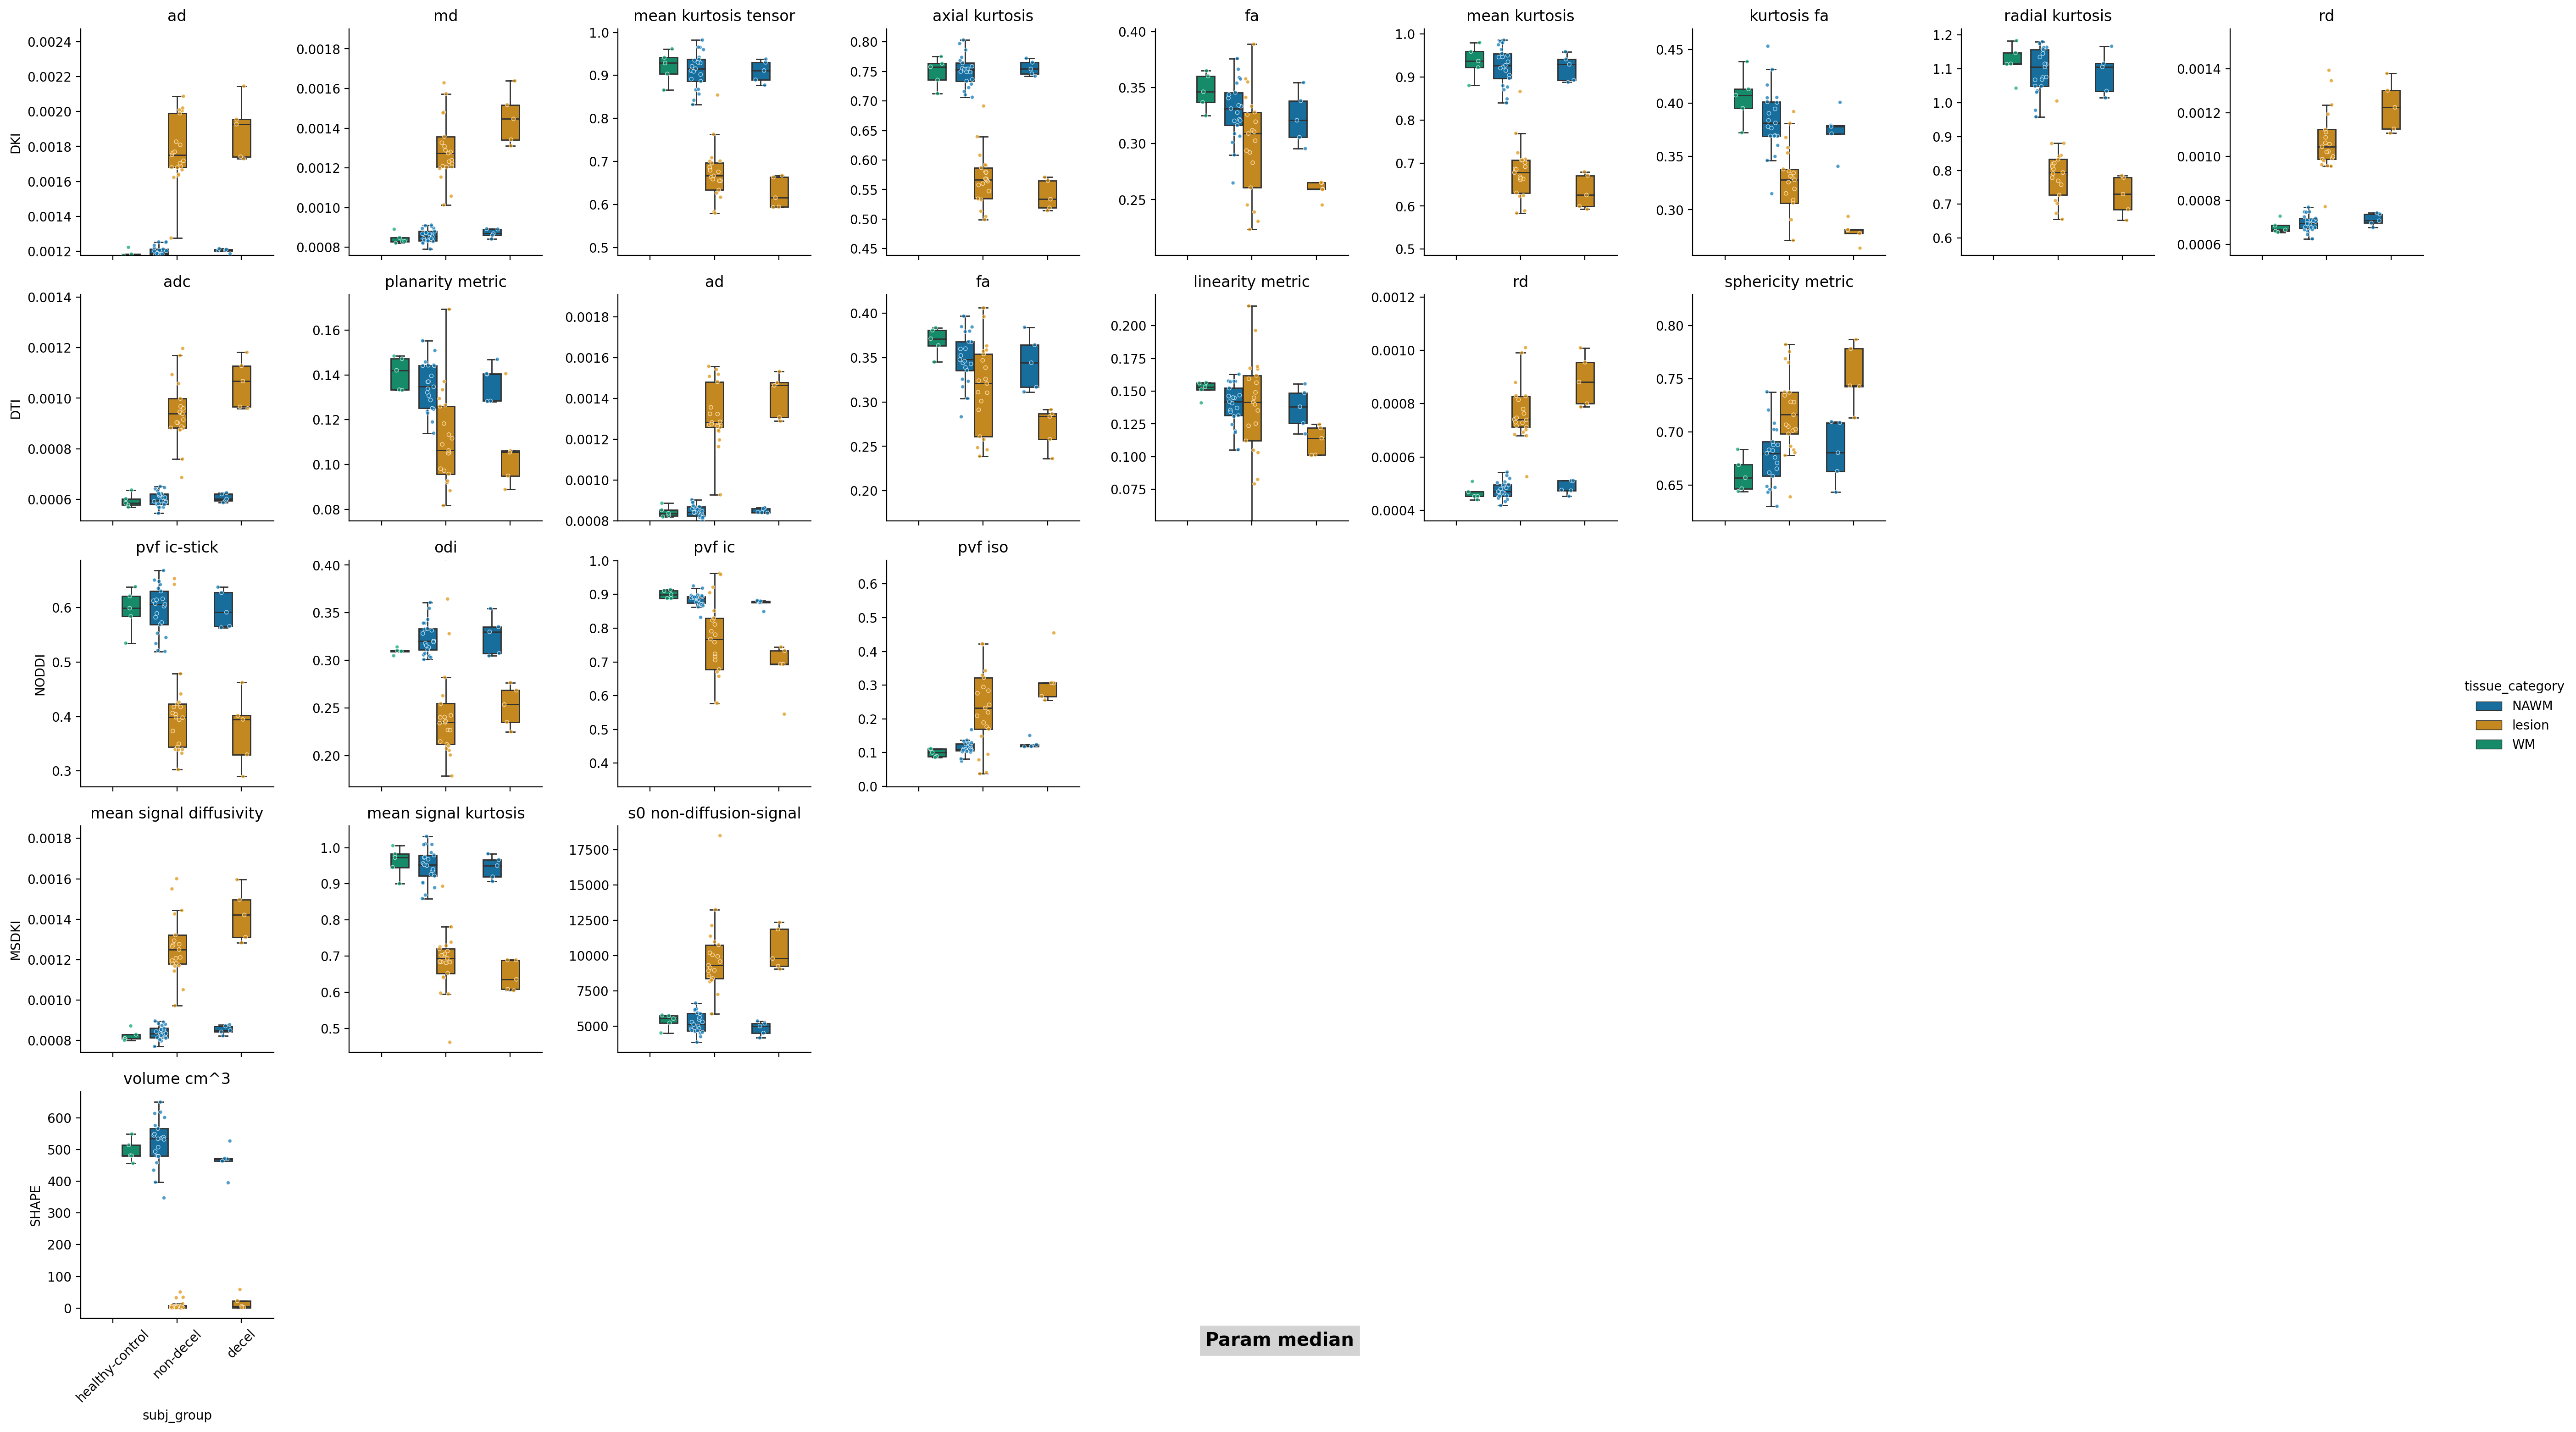

In [20]:
# Plot all WM, NAWM + Lesion tissue scores
plot_table = data_table.copy(deep=True)

n_param_groups = len(plot_table.param_group.unique())

max_num_metrics = 0
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))

print(n_param_groups, max_num_metrics)

col_order = list(map(str, range(max_num_metrics)))
plot_table["col_num"] = "-1"
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    unique_metrics = d.metric_name.unique().tolist()
    metric_col_num = np.arange(len(unique_metrics))[np.argsort(unique_metrics)]
    for n, m in zip(metric_col_num, unique_metrics):

        plot_table.loc[
            (plot_table.param_group == g) & (plot_table.metric_name == m), "col_num"
        ] = str(n)

# Distinguish between patient NAWM, patient lesion, and healthy-control WM
plot_table["tissue_category"] = "n/a"
plot_table.loc[
    (plot_table.subj_group.isin(["decel", "non-decel"]))
    & (plot_table.tissue_type == "lesion"),
    "tissue_category",
] = "lesion"
plot_table.loc[
    (plot_table.subj_group.isin(["decel", "non-decel"]))
    & (plot_table.tissue_type == "nawm"),
    "tissue_category",
] = "NAWM"
plot_table.loc[plot_table.subj_group == "healthy-control", "tissue_category"] = "WM"

plot_tissue_categories = plot_table.tissue_category.unique().flatten().tolist()
assert all([t in tissue_categories for t in plot_tissue_categories])


fig = plt.figure(dpi=200)
g = sns.catplot(
    plot_table,
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="tissue_category",
    row="param_group",
    col="col_num",
    order=x_subj_group_order,
    col_order=col_order,
    row_order=row_order,
    palette=color_palette,
    sharex=True,
    sharey=False,
    width=0.85,
    aspect=1,
    height=3,
    kind="box",
    showfliers=False,
    dodge=True,
    linewidth=1.0,
    # facet_kws={"gridspec_kws":{"hspace": .3}},
)
g = g.map_dataframe(
    sns.stripplot,
    "subj_group",
    # "param_mean",
    parameter_statistic,
    "tissue_category",
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="tissue_category",
    order=x_subj_group_order,
    palette=color_palette,
    edgecolor="white",
    size=3,
    alpha=0.7,
    legend=False,
    dodge=True,
    jitter=0.3,
    linewidth=0.5,
)
g.figure.set_dpi(200)
g.set_xticklabels(rotation=45)


for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        continue

    m = plot_table.loc[
        (plot_table.param_group == param_group) & (plot_table.col_num == col_num)
    ].metric_name.unique()[0]

    ax.set_title(m.replace("_", " "))
    if col_num == "0":
        ax.set_ylabel(param_group.upper())

    # Adjust y-axis bounds to get rid of clear outliers.
    curr_ymin, curr_ymax = ax.get_ylim()
    sub_data = plot_table.loc[
        (plot_table.param_group == param_group) & (plot_table.col_num == col_num)
    ]

    sub_data_grouped = sub_data.groupby(by=["subj_group", "tissue_category"])
    # Set lower-bound, if needed
    low_quantile = sub_data_grouped.quantile(q=0.25, numeric_only=True)
    upper_quantile = sub_data_grouped.quantile(q=0.75, numeric_only=True)
    iqr = upper_quantile - low_quantile

    low_whisker = (low_quantile - (2.0 * iqr)).param_mean.min()
    new_ymin = max(curr_ymin, low_whisker)
    high_whisker = (upper_quantile + (2.0 * iqr)).param_mean.max()
    new_ymax = min(curr_ymax, high_whisker)

    print(
        f"{m} {curr_ymin} | {low_whisker} -> {new_ymin}...{curr_ymax} | {high_whisker} -> {new_ymax}"
    )
    ax.set_ylim(
        bottom=new_ymin if new_ymin != curr_ymin else None,
        top=new_ymax if new_ymax != curr_ymax else None,
        # auto=True
    )


# Empty out subplots with no data available.
for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        ax.set_visible(False)
plt.suptitle(
    parameter_statistic.replace("_", " ").capitalize(),
    y=0.03,
    fontsize="x-large",
    fontweight="heavy",
    backgroundcolor="lightgray",
)
plt.savefig(f"non-decel_vs_decel_vs_control_boxplots_{parameter_statistic}.png")
plt.savefig(f"non-decel_vs_decel_vs_control_boxplots_{parameter_statistic}.pdf")

5 9


<Figure size 1200x800 with 0 Axes>

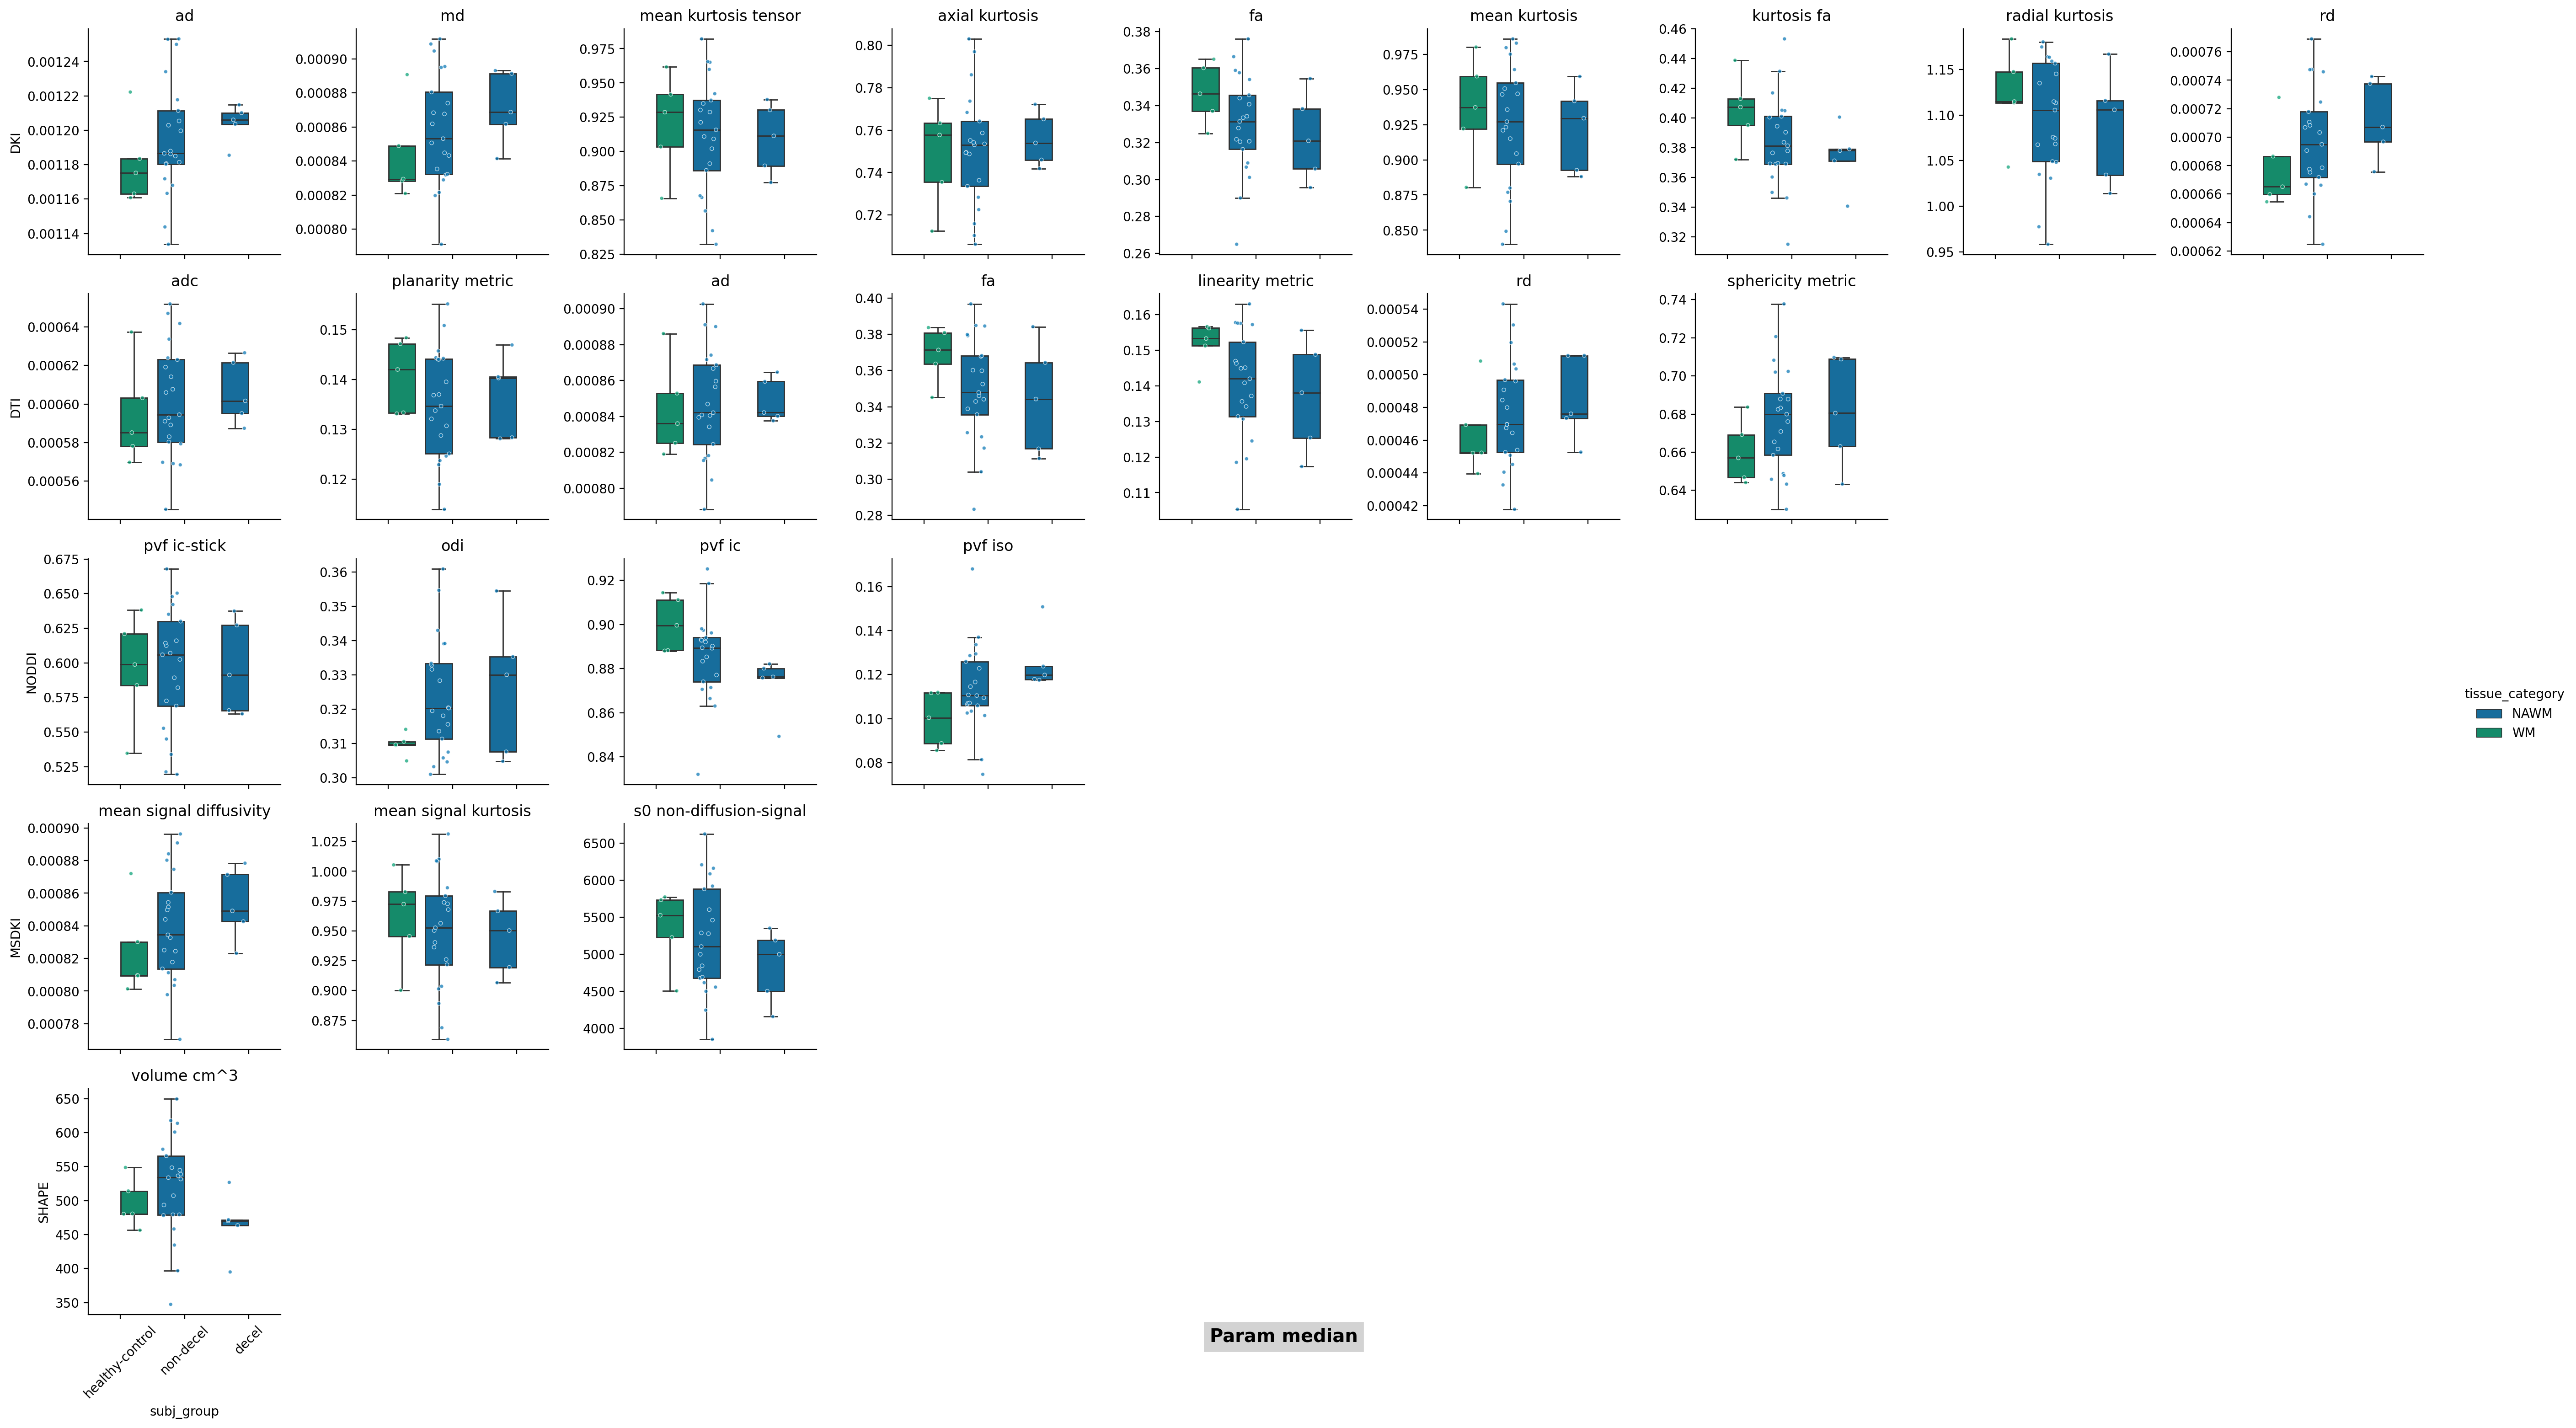

In [21]:
# Plot only WM and NAWM tissue scores
plot_table = data_table.copy(deep=True)

n_param_groups = len(plot_table.param_group.unique())

max_num_metrics = 0
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))

print(n_param_groups, max_num_metrics)

col_order = list(map(str, range(max_num_metrics)))
plot_table["col_num"] = "-1"
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    unique_metrics = d.metric_name.unique().tolist()
    metric_col_num = np.arange(len(unique_metrics))[np.argsort(unique_metrics)]
    for n, m in zip(metric_col_num, unique_metrics):

        plot_table.loc[
            (plot_table.param_group == g) & (plot_table.metric_name == m), "col_num"
        ] = str(n)

# Distinguish between patient NAWM, patient lesion, and healthy-control WM
plot_table["tissue_category"] = "n/a"
plot_table.loc[
    (plot_table.subj_group.isin(["decel", "non-decel"]))
    & (plot_table.tissue_type == "lesion"),
    "tissue_category",
] = "lesion"

plot_table.loc[
    (plot_table.subj_group.isin(["decel", "non-decel"]))
    & (plot_table.tissue_type == "nawm"),
    "tissue_category",
] = "NAWM"
plot_table.loc[plot_table.subj_group == "healthy-control", "tissue_category"] = "WM"

# Remove lesion rows
plot_table = plot_table.loc[plot_table.tissue_category != "lesion"]

plot_tissue_categories = plot_table.tissue_category.unique().flatten().tolist()

fig = plt.figure(dpi=200)
g = sns.catplot(
    plot_table,
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="tissue_category",
    row="param_group",
    col="col_num",
    order=x_subj_group_order,
    col_order=col_order,
    row_order=row_order,
    palette=color_palette,
    sharex=True,
    sharey=False,
    width=0.85,
    aspect=1,
    height=3,
    kind="box",
    showfliers=False,
    dodge=True,
    linewidth=1.0,
    # facet_kws={"gridspec_kws":{"hspace": .3}},
)
g = g.map_dataframe(
    sns.stripplot,
    "subj_group",
    # "param_mean",
    parameter_statistic,
    "tissue_category",
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="tissue_category",
    order=x_subj_group_order,
    palette=color_palette,
    edgecolor="white",
    size=3,
    alpha=0.7,
    legend=False,
    dodge=True,
    jitter=0.3,
    linewidth=0.5,
)
g.figure.set_dpi(200)
g.set_xticklabels(rotation=45)

for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        continue

    m = plot_table.loc[
        (plot_table.param_group == param_group) & (plot_table.col_num == col_num)
    ].metric_name.unique()[0]

    ax.set_title(m.replace("_", " "))
    if col_num == "0":
        ax.set_ylabel(param_group.upper())

# Empty out subplots with no data available.
for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        ax.set_visible(False)

plt.suptitle(
    parameter_statistic.replace("_", " ").capitalize(),
    y=0.03,
    fontsize="x-large",
    fontweight="heavy",
    backgroundcolor="lightgray",
)
plt.savefig(f"WM-only_nondecel-decel-control_boxplots_{parameter_statistic}.png")
plt.savefig(f"WM-only_nondecel-decel-control_boxplots_{parameter_statistic}.pdf")

#### Non-Healthy Control Comparisons

5 9


<Figure size 1200x800 with 0 Axes>

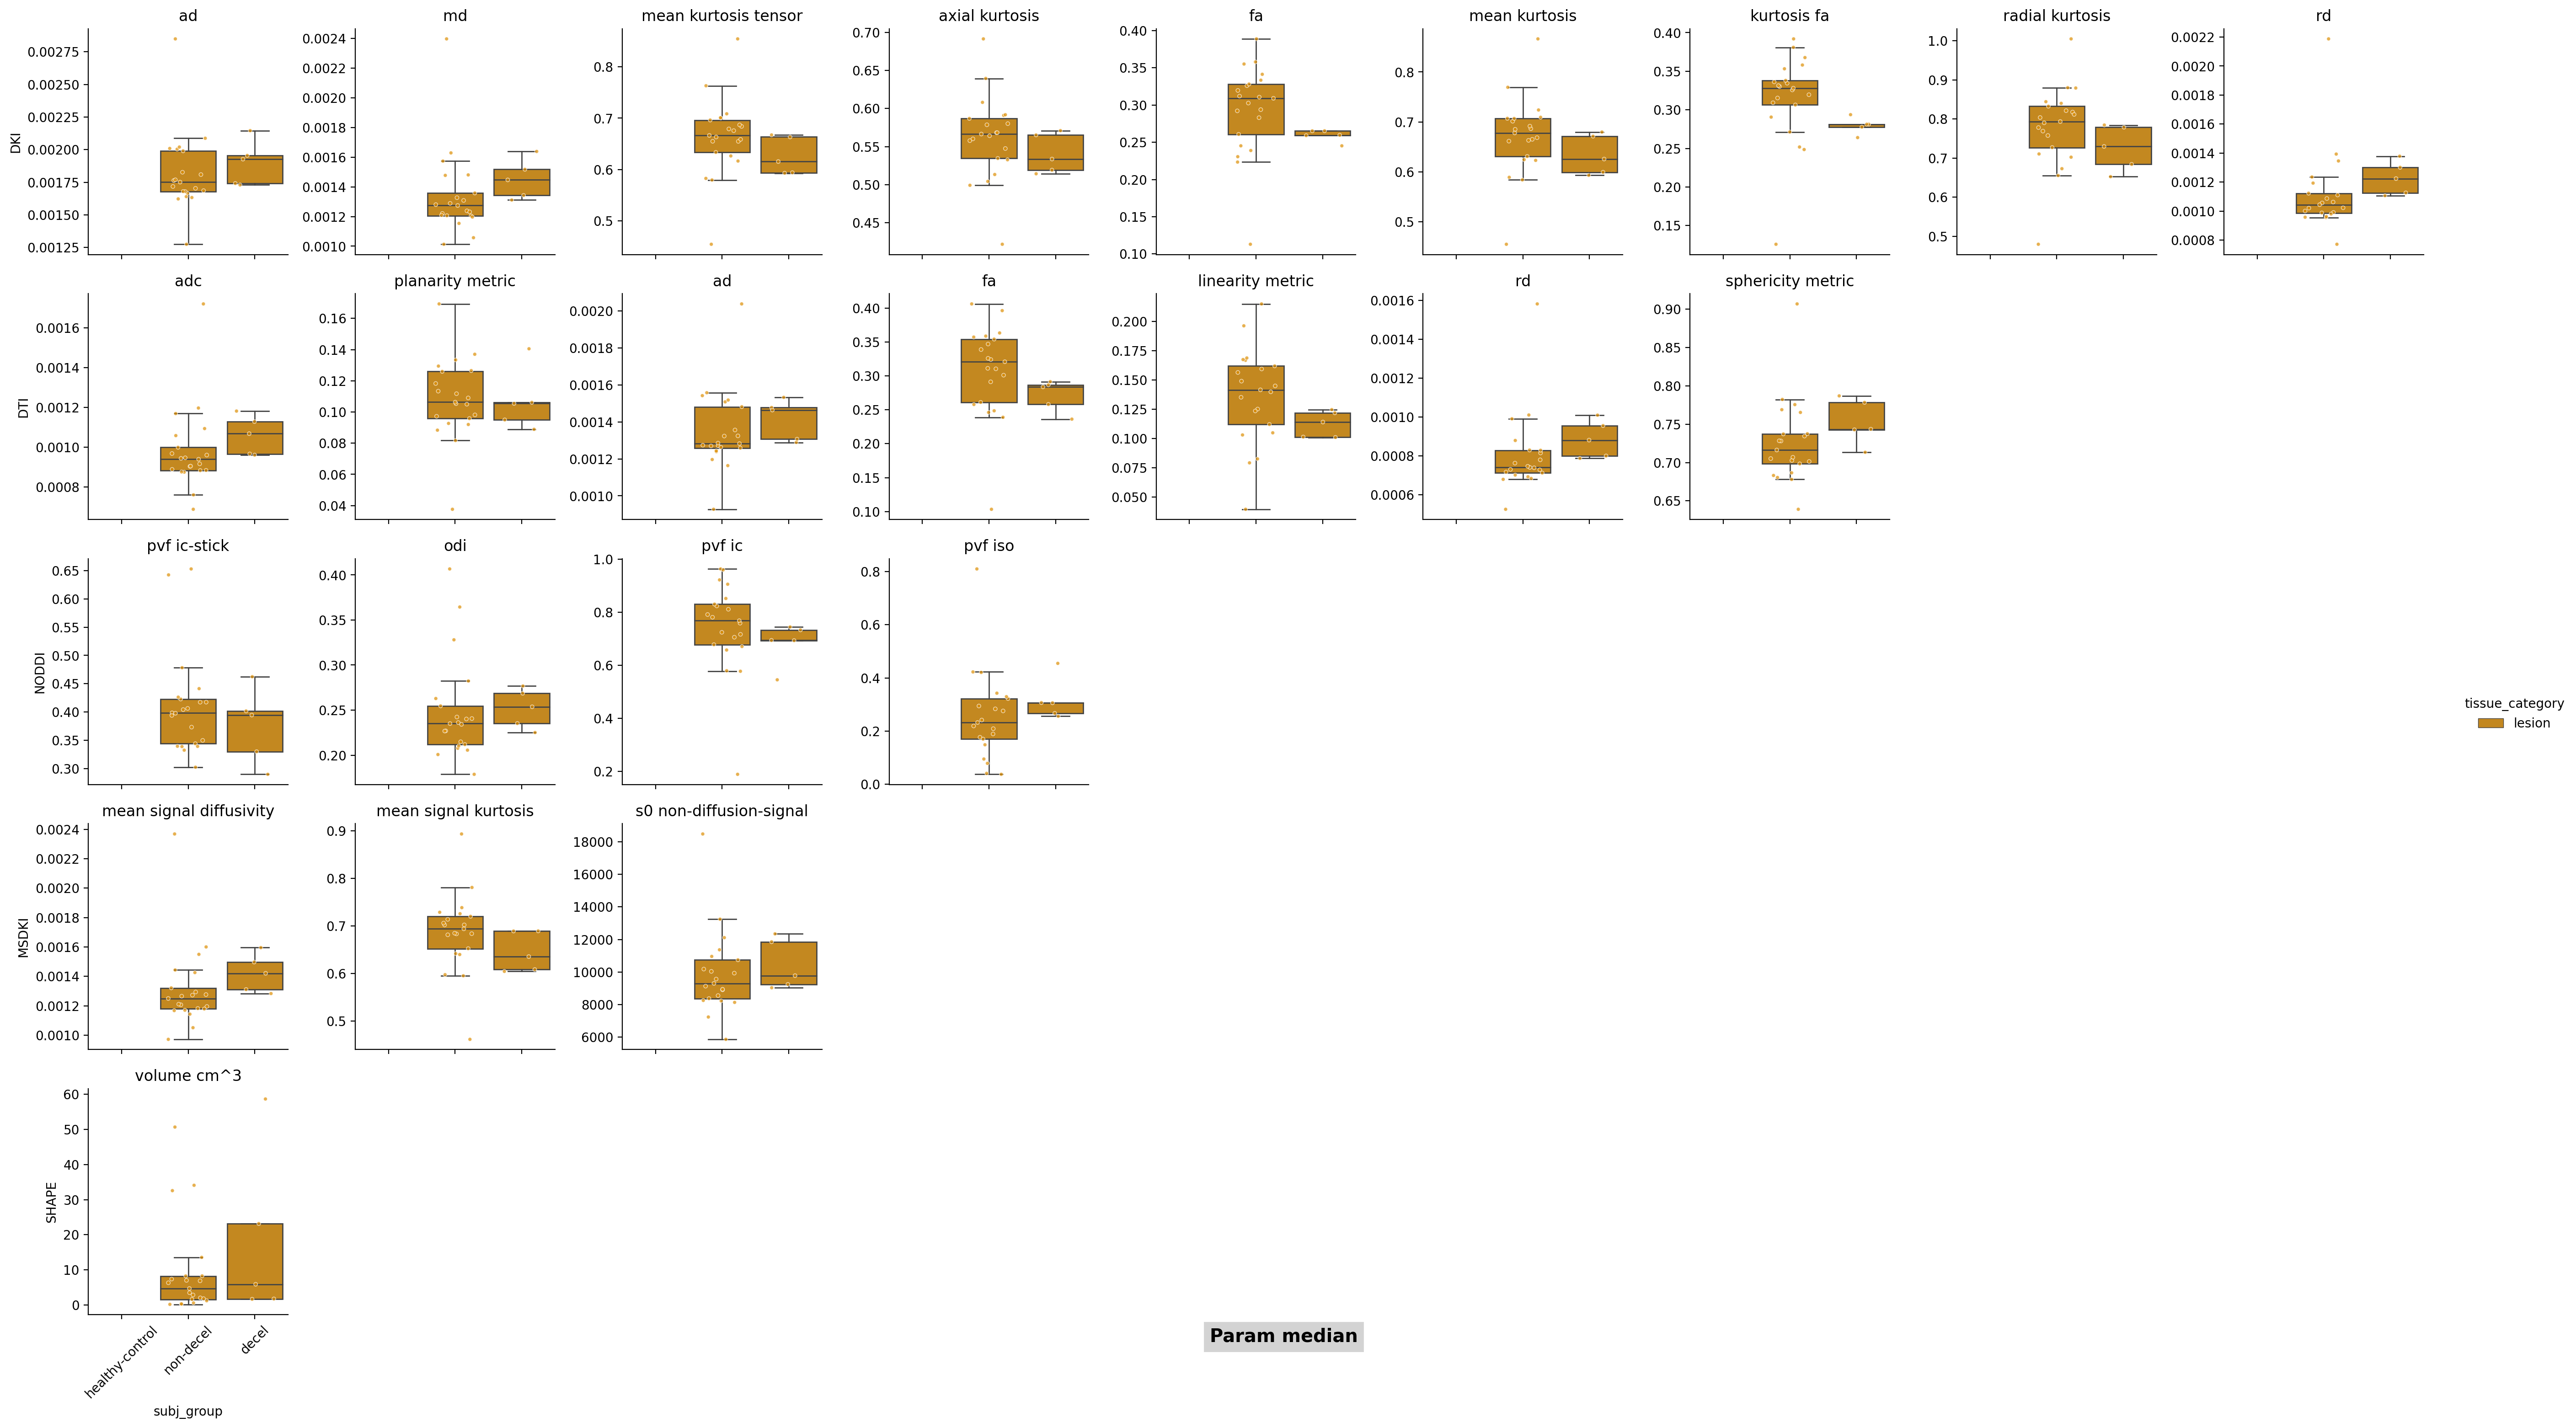

In [22]:
# Plot only lesion tissue scores between non-decel and decel patients.
plot_table = data_table.copy(deep=True)

n_param_groups = len(plot_table.param_group.unique())

max_num_metrics = 0
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))

print(n_param_groups, max_num_metrics)

col_order = list(map(str, range(max_num_metrics)))
plot_table["col_num"] = "-1"
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    unique_metrics = d.metric_name.unique().tolist()
    metric_col_num = np.arange(len(unique_metrics))[np.argsort(unique_metrics)]
    for n, m in zip(metric_col_num, unique_metrics):

        plot_table.loc[
            (plot_table.param_group == g) & (plot_table.metric_name == m), "col_num"
        ] = str(n)

# Distinguish between patient NAWM, patient lesion, and healthy-control WM
plot_table["tissue_category"] = "n/a"
plot_table.loc[
    (plot_table.subj_group.isin(["decel", "non-decel"]))
    & (plot_table.tissue_type == "lesion"),
    "tissue_category",
] = "lesion"

plot_table.loc[
    (plot_table.subj_group.isin(["decel", "non-decel"]))
    & (plot_table.tissue_type == "nawm"),
    "tissue_category",
] = "NAWM"
plot_table.loc[plot_table.subj_group == "healthy-control", "tissue_category"] = "WM"

# Remove healthy controls and NAWM tissue rows
plot_table = plot_table.loc[plot_table.tissue_category == "lesion"]

plot_tissue_categories = plot_table.tissue_category.unique().flatten().tolist()

fig = plt.figure(dpi=200)
g = sns.catplot(
    plot_table,
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="tissue_category",
    row="param_group",
    col="col_num",
    order=x_subj_group_order,
    col_order=col_order,
    row_order=row_order,
    palette=color_palette,
    sharex=True,
    sharey=False,
    width=0.85,
    aspect=1,
    height=3,
    kind="box",
    showfliers=False,
    dodge=True,
    linewidth=1.0,
    # facet_kws={"gridspec_kws":{"hspace": .3}},
)
g = g.map_dataframe(
    sns.stripplot,
    "subj_group",
    # "param_mean",
    parameter_statistic,
    "tissue_category",
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="tissue_category",
    order=x_subj_group_order,
    palette=color_palette,
    edgecolor="white",
    size=3,
    alpha=0.7,
    legend=False,
    dodge=True,
    jitter=0.3,
    linewidth=0.5,
)
g.figure.set_dpi(200)
g.set_xticklabels(rotation=45)

for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        continue

    m = plot_table.loc[
        (plot_table.param_group == param_group) & (plot_table.col_num == col_num)
    ].metric_name.unique()[0]

    ax.set_title(m.replace("_", " "))
    if col_num == "0":
        ax.set_ylabel(param_group.upper())

# Empty out subplots with no data available.
for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        ax.set_visible(False)

plt.suptitle(
    parameter_statistic.replace("_", " ").capitalize(),
    y=0.03,
    fontsize="x-large",
    fontweight="heavy",
    backgroundcolor="lightgray",
)
plt.savefig(f"lesion-only_nondecel-decel_boxplots_{parameter_statistic}.png")
plt.savefig(f"lesion-only_nondecel-decel_boxplots_{parameter_statistic}.pdf")

In [ ]:
# Compare only patient (non-healthy controls) distributions.

metrics_of_interest = (
    "pvf_ic",
    "pvf_iso",
    "odi",
    "fa",
    "md",
    "ad",
    "adc",
    "rd",
    "mean_kurtosis",
    "radial_kurtosis",
    "axial_kurtosis",
    "kurtosis_fa",
)
groups_of_interest = ("dki", "noddi", "dti")
non_control_subjs = set(subj_list) - control_subjs

d_sub_dist = data_table[
    data_table.param_group.isin(groups_of_interest)
    & data_table.metric_name.isin(metrics_of_interest)
    * data_table.subj_id.isin(non_control_subjs)
]

s_sub_dist = stats_table[
    stats_table.param_group.isin(groups_of_interest)
    & stats_table.metric_name.isin(metrics_of_interest)
    * stats_table.subj_id.isin(non_control_subjs)
]

n_groups = len(d_sub_dist.param_group.unique())

max_num_metrics = 0
for g in d_sub_dist.param_group.unique():
    d = d_sub_dist.loc[d_sub_dist.param_group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))

In [ ]:
# Grid of decel individuals vs. non-decel distributions
with sns.plotting_context("talk", 0.8):
    fig = plt.figure(
        dpi=250, figsize=(max_num_metrics * 3, n_groups * 4), layout="constrained"
    )
    gs = mpl.gridspec.GridSpec(nrows=n_groups, ncols=max_num_metrics, figure=fig)

    # Iterate over rows/groups
    for i_g, g in enumerate(d_sub_dist.param_group.unique()):
        d_g = d_sub_dist.loc[d_sub_dist.param_group == g, :]
        # Iterate over variable-length columns/metrics
        for j_m, m in itertools.zip_longest(
            range(max_num_metrics), d_g.metric_name.unique(), fillvalue=None
        ):
            if m is None:
                break
            ax = fig.add_subplot(gs[i_g, j_m])
            d = d_g.loc[d_g.metric_name == m, :]
            if d.shape[0] == 0:
                continue

            # Revert the naming cleanup to get back the filenames.
            if m == "odi":
                m_orig = "wm-Watson-bundle_odi"
            elif m == "pvf_ic":
                m_orig = "partial_volume_fraction_wm-intra-cellular-Watson-bundle"
            elif m == "pvf_iso":
                m_orig = "partial_volume_fraction_csf-isotropic-ball"
            elif m == "pvf_ic-stick":
                m_orig = "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle"
            else:
                m_orig = m

            pooled_nondecel_wm = list()
            pooled_nondecel_lesion = list()
            pooled_decel_wm_stats = list()
            pooled_decel_lesion_stats = list()
            for subj_id in subj_list:
                d_files = subj_data[subj_id].files
                lesion_mask = (
                    nib.load(d_files.diffusion.lesion_mask).get_fdata().astype(bool)
                )
                wm_mask = nib.load(d_files.diffusion.wm_mask).get_fdata().astype(bool)
                wm_mask = wm_mask * (~lesion_mask)

                p_f = d_files.diffusion.param_maps[g][m_orig]
                p_im = nib.load(p_f).get_fdata().astype(np.float32)
                # Ignore multi-dimensional parameters for now.
                if len(p_im.shape) == 4:
                    continue
                if subj_id in decel_subjs:
                    wm_stat = np.nanmedian(p_im[wm_mask])
                    lesion_stat = np.nanmedian(p_im[lesion_mask])
                    pooled_decel_wm_stats.append(wm_stat)
                    pooled_decel_lesion_stats.append(lesion_stat)
                else:
                    pooled_nondecel_wm.append(p_im[wm_mask])
                    pooled_nondecel_lesion.append(p_im[lesion_mask])

            pooled_nondecel_wm = np.concatenate(pooled_nondecel_wm).flatten()
            pooled_nondecel_wm = np.clip(
                pooled_nondecel_wm, a_min=None, a_max=5 * np.median(pooled_nondecel_wm)
            )

            pooled_nondecel_lesion = np.concatenate(pooled_nondecel_lesion).flatten()
            pooled_nondecel_lesion = np.clip(
                pooled_nondecel_lesion,
                a_min=None,
                a_max=5 * np.median(pooled_nondecel_lesion),
            )
            pooled_decel_wm_stats = np.array(pooled_decel_wm_stats).flatten()
            pooled_decel_lesion_stats = np.array(pooled_decel_lesion_stats).flatten()

            nondecel_wm_mean = np.nanmean(pooled_nondecel_wm)
            nondecel_wm_std = np.nanstd(pooled_nondecel_wm)
            nondecel_lesion_mean = np.nanmean(pooled_nondecel_lesion)
            nondecel_lesion_std = np.nanstd(pooled_nondecel_lesion)
            wm_rv = scipy.stats.norm(loc=nondecel_wm_mean, scale=nondecel_wm_std)
            wm_x = wm_rv.rvs(50000)
            lesion_rv = scipy.stats.norm(
                loc=nondecel_lesion_mean, scale=nondecel_lesion_std
            )
            lesion_x = lesion_rv.rvs(50000)

            nondecel_y = list()
            nondecel_x = list()
            nondecel_dist_source = list()
            nondecel_y.append(wm_x)
            nondecel_x.extend(["WM"] * len(wm_x))
            nondecel_dist_source.extend(["Gaussian Fit"] * len(wm_x))
            nondecel_y.append(pooled_nondecel_wm)
            nondecel_x.extend(["WM"] * len(pooled_nondecel_wm))
            nondecel_dist_source.extend(["Empirical KDE"] * len(pooled_nondecel_wm))
            nondecel_y.append(lesion_x)
            nondecel_x.extend(["Lesion"] * len(lesion_x))
            nondecel_dist_source.extend(["Gaussian Fit"] * len(lesion_x))
            nondecel_y.append(pooled_nondecel_lesion)
            nondecel_x.extend(["Lesion"] * len(pooled_nondecel_lesion))
            nondecel_dist_source.extend(["Empirical KDE"] * len(pooled_nondecel_lesion))
            nondecel_y = np.concatenate(nondecel_y).flatten()

            nondecel_data = pd.DataFrame.from_dict(
                {
                    "val": nondecel_y,
                    "tissue": nondecel_x,
                    "dist_source": nondecel_dist_source,
                }
            )

            # Plot decel subjects summary stat of choice.
            ax = sns.violinplot(
                nondecel_data,
                x="tissue",
                y="val",
                hue="dist_source",
                split=True,
                inner=None,
                legend=False,
                scale="width",
                width=0.9,
                ax=ax,
                cut=0,
            )
            violin_ymin, violin_ymax = ax.get_ylim()
            violin_xmin, violin_xmax = ax.get_xlim()

            ax = sns.scatterplot(
                x=["WM"] * len(pooled_decel_wm_stats),
                y=pooled_decel_wm_stats,
                ax=ax,
                color="black",
                alpha=0.5,
            )
            ax = sns.scatterplot(
                x=["Lesion"] * len(pooled_decel_lesion_stats),
                y=pooled_decel_lesion_stats,
                ax=ax,
                color="black",
                alpha=0.5,
            )

            ax.set_xlim(violin_xmin, violin_xmax)
            ax.set_ylim(violin_ymin, violin_ymax)
            ax.grid(axis="y", zorder=1)
            ax.set_title(m)
            if j_m == 0:
                ax.set_ylabel(g.upper())
            else:
                ax.set_ylabel(None)
            ax.set_xlabel(None)
            if i_g == j_m == 0:
                pass
            else:
                ax.get_legend().remove()
            print(g, "-", m)

plt.show()

## ROI Statistics

In [23]:
roi_data_table = {
    "subj_id": list(),
    "subj_group": list(),
    "roi": list(),
    "param_group": list(),
    "metric_name": list(),
    "param_mean": list(),
    "param_median": list(),
    "param_std": list(),
}

for subj_id in subj_list:
    print(subj_id)
    d = subj_data[subj_id]
    lesion_mask = nib.load(d.files.diffusion.lesion_mask).get_fdata().astype(bool)
    wm_mask = nib.load(d.files.diffusion.wm_mask).get_fdata().astype(bool)
    wm_mask = wm_mask * (~lesion_mask)

    # For all parameter groups.
    for g, p in d.files.diffusion.param_maps.items():
        # For all parameters in a parameter group.
        for p_name, p_f in p.items():
            p_im = nib.load(p_f).get_fdata().astype(np.float32)
            # Ignore multi-dimensional parameters for now.
            if len(p_im.shape) == 4:
                continue

            # For all ROIs
            for roi_name, roi_f in d.files.roi.items():
                roi_mask = nib.load(roi_f).get_fdata().astype(bool)

                # Add a row for the ROI mask in its entirety, including voxels that may
                # be lesion or non-NAWM.
                a = p_im[roi_mask]
                a = a[~np.isnan(a)]
                roi_data_table["subj_id"].append(subj_id)
                if subj_id in decel_subjs:
                    roi_data_table["subj_group"].append("decel")
                elif subj_id in control_subjs:
                    roi_data_table["subj_group"].append("healthy-control")
                else:
                    roi_data_table["subj_group"].append("non-decel")
                roi_data_table["roi"].append(roi_name)
                roi_data_table["param_group"].append(g)
                roi_data_table["metric_name"].append(p_name)
                roi_data_table["param_mean"].append(a.mean())
                roi_data_table["param_median"].append(np.median(a))
                roi_data_table["param_std"].append(a.std())
                if np.isnan(roi_data_table["param_mean"][-1]).any() or np.isnan(
                    roi_data_table["param_std"][-1].any()
                ):
                    print(g, p_name, l, "has NaN")
                    print(np.isnan(a).sum(), "/", np.prod(a.shape))

                # Row for the ROI intersected with NAWM.
                roi_and_nawm_mask = roi_mask & wm_mask
                roi_intersect_name = f"{roi_name}_INTERSECT_nawm"
                # Select only voxels that are within the roi mask and remove NaNs.
                a = p_im[roi_and_nawm_mask]
                a = a[~np.isnan(a)]

                roi_data_table["subj_id"].append(subj_id)
                if subj_id in decel_subjs:
                    roi_data_table["subj_group"].append("decel")
                elif subj_id in control_subjs:
                    roi_data_table["subj_group"].append("healthy-control")
                else:
                    roi_data_table["subj_group"].append("non-decel")
                roi_data_table["roi"].append(roi_intersect_name)
                roi_data_table["param_group"].append(g)
                roi_data_table["metric_name"].append(p_name)
                roi_data_table["param_mean"].append(a.mean())
                roi_data_table["param_median"].append(np.median(a))
                roi_data_table["param_std"].append(a.std())
                if np.isnan(roi_data_table["param_mean"][-1]).any() or np.isnan(
                    roi_data_table["param_std"][-1].any()
                ):
                    print(g, p_name, l, "has NaN")
                    print(np.isnan(a).sum(), "/", np.prod(a.shape))

    roi_intersect_lesion_mask = roi_mask & lesion_mask
    print(
        f"{roi_name}",
        f"ROI x Lesion amt. {roi_intersect_lesion_mask.sum()}",
        f"ROI x NAWM amnt. {roi_and_nawm_mask.sum()}",
    )
    # Also add physical volume.
    brain_mask = nib.load(d.files.diffusion.mask).get_fdata().astype(bool)
    brain_vol_cm3 = brain_mask.sum() * voxel_vol_cm3
    for roi_name, roi_f in d.files.roi.items():
        roi_mask = nib.load(roi_f).get_fdata().astype(bool)
        roi_vol = roi_mask.sum() * voxel_vol_cm3
        roi_vol_normalized = roi_mask.sum() / brain_mask.sum()

        roi_and_nawm_mask = roi_mask & wm_mask
        roi_intersect_name = f"{roi_name}_INTERSECT_nawm"
        # Get the absolute roi volume in cm^3
        roi_intersect_vol_cm3 = roi_and_nawm_mask.sum() * voxel_vol_cm3
        # Normalize by the total brain volume.
        roi_intersect_vol_normalized = roi_and_nawm_mask.sum() / brain_mask.sum()

        vols = {
            roi_name: {"volume cm^3": roi_vol, "normalized volume": roi_vol_normalized},
            roi_intersect_name: {
                "volume cm^3": roi_intersect_vol_cm3,
                "normalized volume": roi_intersect_vol_normalized,
            },
        }

        for name in vols.keys():
            for met_name in vols[name].keys():
                v = vols[name][met_name]

                roi_data_table["subj_id"].append(subj_id)
                if subj_id in decel_subjs:
                    roi_data_table["subj_group"].append("decel")
                elif subj_id in control_subjs:
                    roi_data_table["subj_group"].append("healthy-control")
                else:
                    roi_data_table["subj_group"].append("non-decel")
                roi_data_table["roi"].append(name)
                roi_data_table["param_group"].append("shape")
                roi_data_table["metric_name"].append(met_name)
                roi_data_table["param_mean"].append(v)
                roi_data_table["param_median"].append(v)
                roi_data_table["param_std"].append(0)

roi_data_table_bak = pd.DataFrame.from_dict(roi_data_table)
roi_data_table = roi_data_table_bak.copy(deep=True)

# Rename some of the crazier names.
roi_data_table.loc[
    roi_data_table.metric_name == "wm-Watson-bundle_odi",
    "metric_name",
] = "odi"
roi_data_table.loc[
    roi_data_table.metric_name
    == "partial_volume_fraction_wm-intra-cellular-Watson-bundle",
    "metric_name",
] = "pvf_ic"
roi_data_table.loc[
    roi_data_table.metric_name == "partial_volume_fraction_csf-isotropic-ball",
    "metric_name",
] = "pvf_iso"
roi_data_table.loc[
    roi_data_table.metric_name
    == "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle",
    "metric_name",
] = "pvf_ic-stick"

P_01
cst ROI x Lesion amt. 1 ROI x NAWM amnt. 1944
P_02
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 1950
P_03
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 1108
P_04
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 2007
P_05
cst ROI x Lesion amt. 387 ROI x NAWM amnt. 2112
P_06
cst ROI x Lesion amt. 49 ROI x NAWM amnt. 2464
P_07
cst ROI x Lesion amt. 3 ROI x NAWM amnt. 1491
P_08
cst ROI x Lesion amt. 16 ROI x NAWM amnt. 1474
P_10
cst ROI x Lesion amt. 63 ROI x NAWM amnt. 1682
P_11
cst ROI x Lesion amt. 7 ROI x NAWM amnt. 2145
P_13
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 2456
P_14
cst ROI x Lesion amt. 3 ROI x NAWM amnt. 2006
P_19
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 2473
P_20
cst ROI x Lesion amt. 15 ROI x NAWM amnt. 1820
P_21
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 2127
P_22
cst ROI x Lesion amt. 1 ROI x NAWM amnt. 1900
P_23
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 349
P_24
cst ROI x Lesion amt. 0 ROI x NAWM amnt. 1570
P_25
cst ROI x Lesion amt. 300 ROI x NAWM amnt. 1930
P_26
cst ROI x Lesion am

In [24]:
roi_data_table

subj_id       subj_group                 roi param_group  \
0       P_01        non-decel                 cst       msdki   
1       P_01        non-decel  cst_INTERSECT_nawm       msdki   
2       P_01        non-decel                 cst       msdki   
3       P_01        non-decel  cst_INTERSECT_nawm       msdki   
4       P_01        non-decel                 cst       msdki   
...      ...              ...                 ...         ...   
1545   HC_05  healthy-control  cst_INTERSECT_nawm       noddi   
1546   HC_05  healthy-control                 cst       shape   
1547   HC_05  healthy-control                 cst       shape   
1548   HC_05  healthy-control  cst_INTERSECT_nawm       shape   
1549   HC_05  healthy-control  cst_INTERSECT_nawm       shape   

                  metric_name   param_mean  param_median    param_std  
0     s0_non-diffusion-signal  8653.399414   6869.451172  4907.595703  
1     s0_non-diffusion-signal  7657.450684   6789.010742  3166.770264  
2        mean_signal_kurtosis     1.020154      1.127584     0.270168  
3        mean_signal_kurtosis     1.095540      1.166418     0.203872  
4     mean_signal_diffusivity     0.001033      0.000783     0.000575  
...                       ...          ...           ...          ...  
1545                  pvf_iso     0.187831      0.158491     0.152344  
1546              volume cm^3    27.667969     27.667969     0.000000  
1547        normalized volume     0.016624      0.016624     0.000000  
1548              volume cm^3    22.211719     22.211719     0.000000  
1549        normalized volume     0.013346      0.013346     0.000000  

[1550 rows x 8 columns]

In [25]:
roi_data_table.to_csv("vcu_ms_data_diffusion-metrics_control-nawm_roi_stats.csv")

### Plot Parameter Distributions in ROIs

In [27]:
# Standardize the order of plotting in all plots.
rois = ("cst_INTERSECT_nawm",)
n_rois = len(rois)
color_palette = sns.color_palette("colorblind", n_colors=n_rois)
color_palette = {rois[i]: color_palette[i] for i in range(n_rois)}

x_subj_group_order = ("healthy-control", "non-decel", "decel")
row_order = ("dki", "dti", "noddi", "msdki", "shape")

parameter_statistic = "param_median"

5 9


<Figure size 1200x800 with 0 Axes>

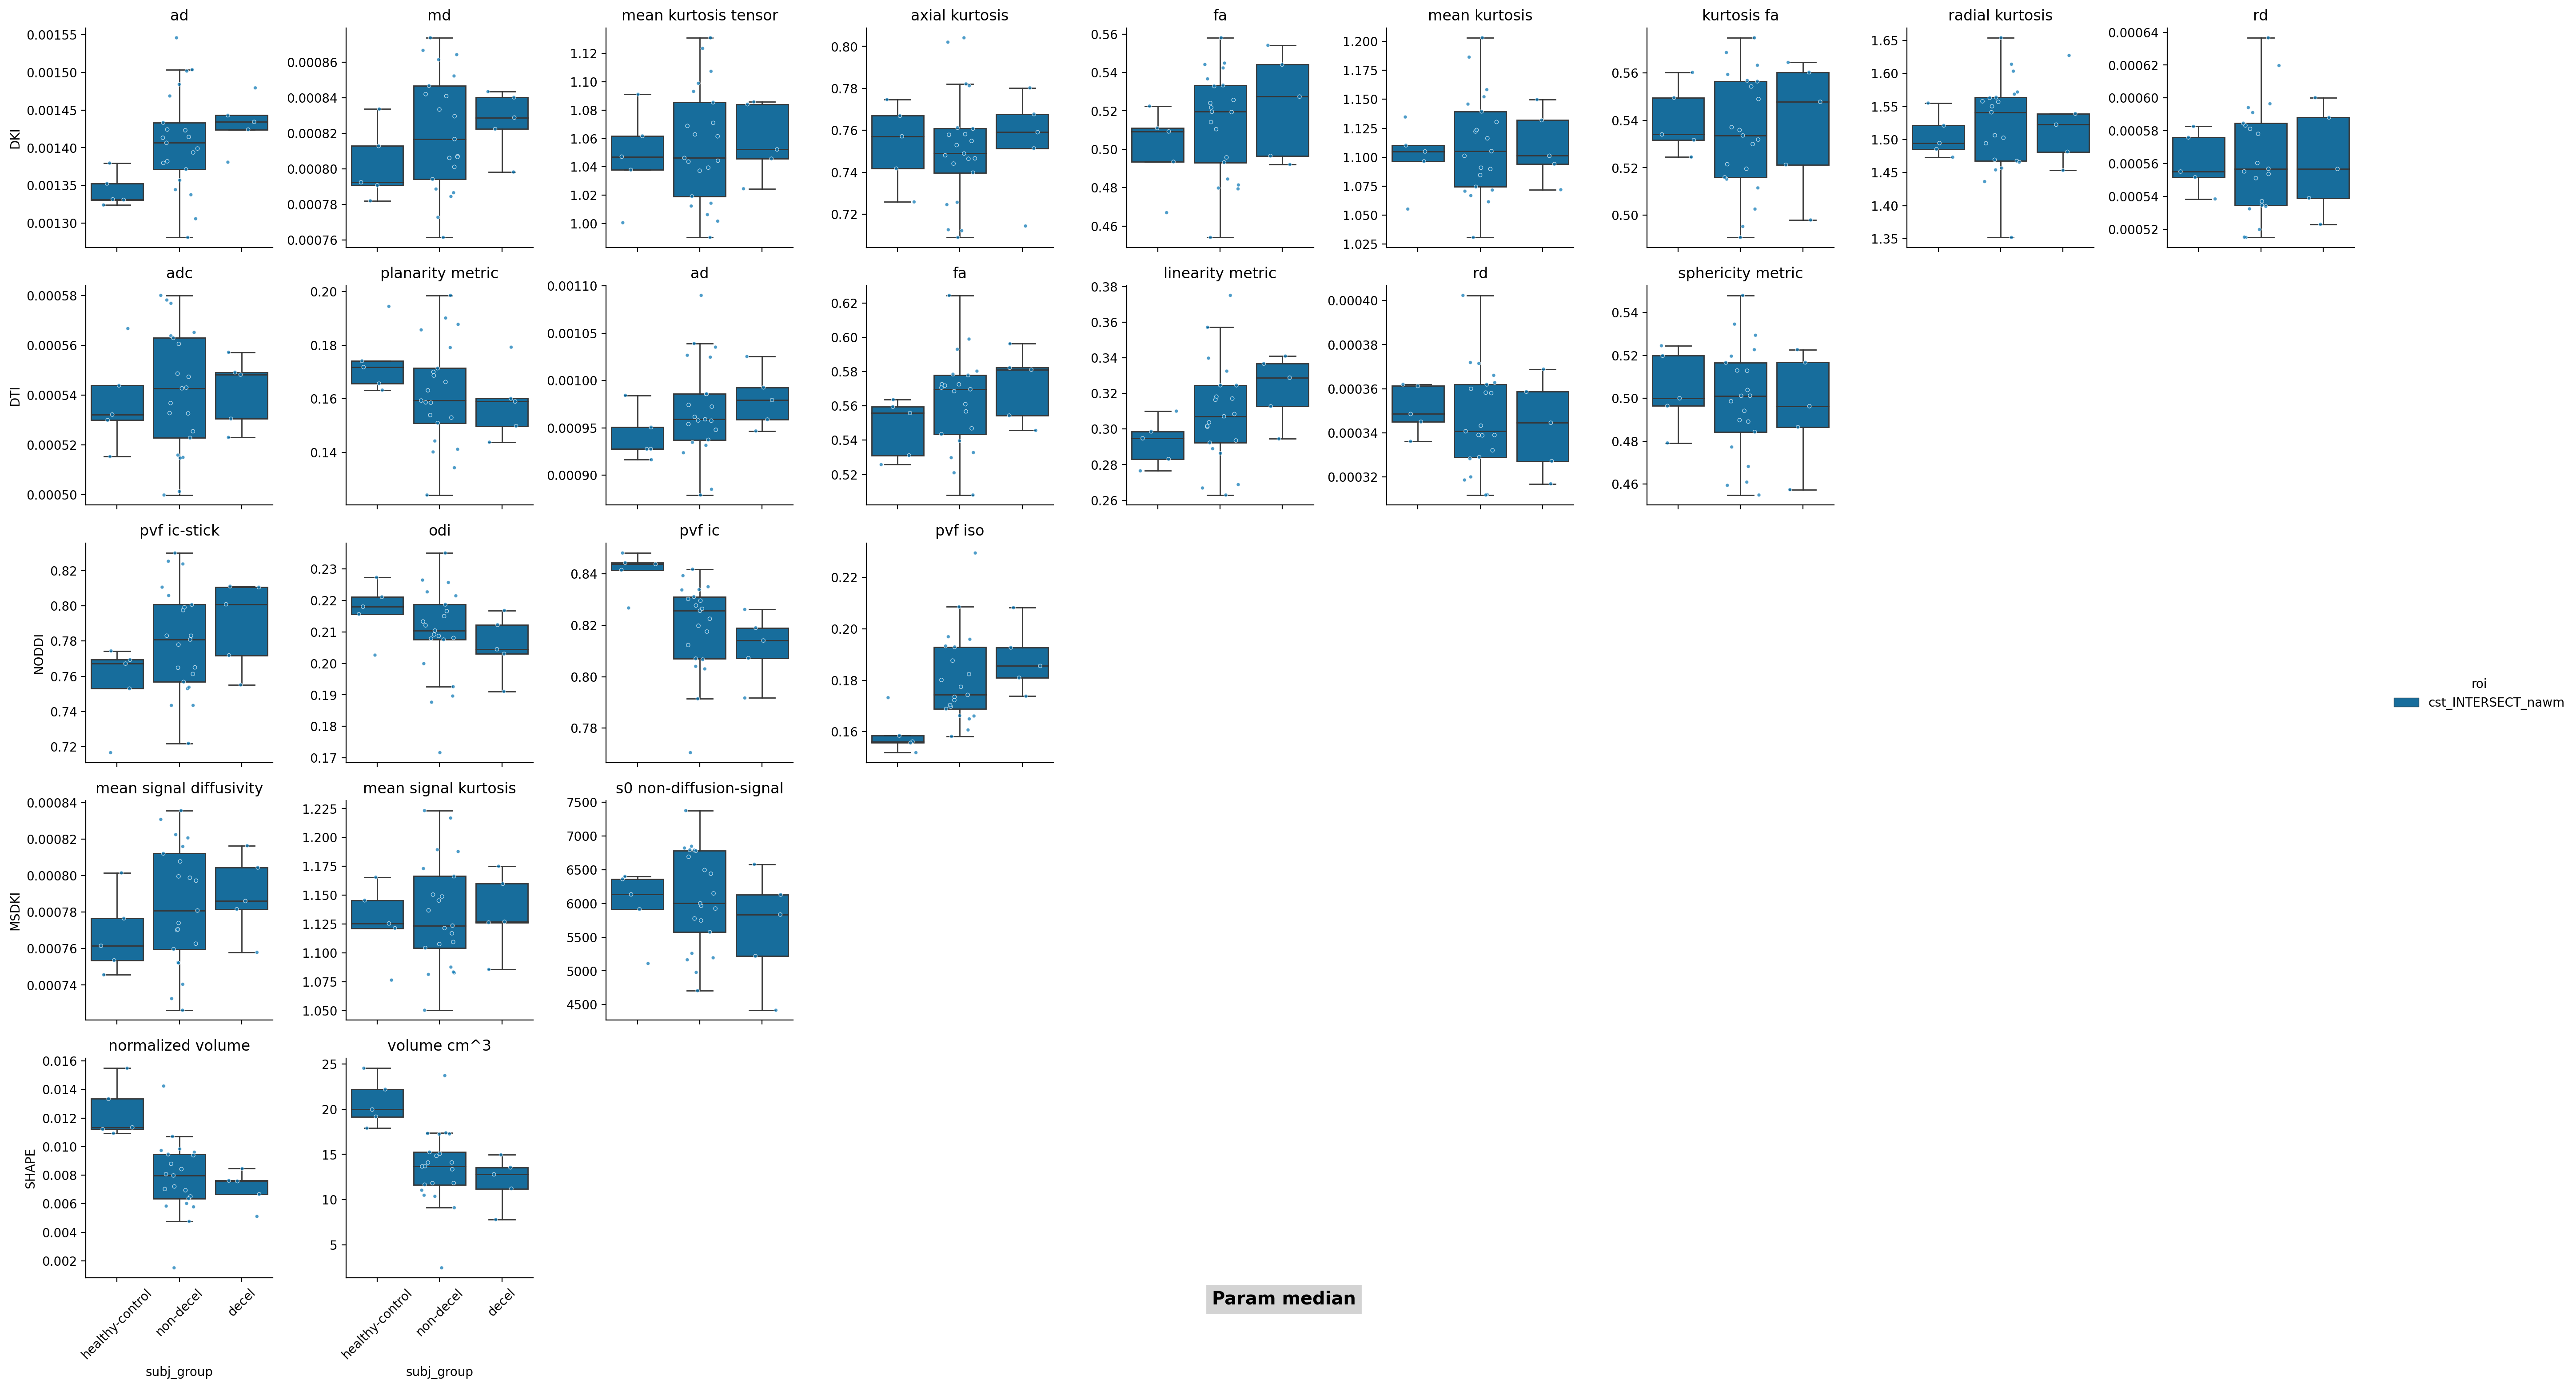

In [28]:
# Plot a selected ROI's parameter statistics.
selected_roi = "cst_INTERSECT_nawm"

plot_table = roi_data_table.copy(deep=True)
# Subset the plot table to the selected ROI
plot_table = plot_table.loc[plot_table.roi == selected_roi]

n_param_groups = len(plot_table.param_group.unique())

max_num_metrics = 0
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))

print(n_param_groups, max_num_metrics)

col_order = list(map(str, range(max_num_metrics)))
plot_table["col_num"] = "-1"
for g in plot_table.param_group.unique():
    d = plot_table.loc[plot_table.param_group == g, :]
    unique_metrics = d.metric_name.unique().tolist()
    metric_col_num = np.arange(len(unique_metrics))[np.argsort(unique_metrics)]
    for n, m in zip(metric_col_num, unique_metrics):

        plot_table.loc[
            (plot_table.param_group == g) & (plot_table.metric_name == m), "col_num"
        ] = str(n)


fig = plt.figure(dpi=200)
g = sns.catplot(
    plot_table,
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="roi",
    row="param_group",
    col="col_num",
    order=x_subj_group_order,
    col_order=col_order,
    row_order=row_order,
    palette=color_palette,
    sharex=True,
    sharey=False,
    width=0.85,
    aspect=1,
    height=3,
    kind="box",
    showfliers=False,
    dodge=True,
    linewidth=1.0,
    # facet_kws={"gridspec_kws":{"hspace": .3}},
)
g = g.map_dataframe(
    sns.stripplot,
    "subj_group",
    # "param_mean",
    parameter_statistic,
    "roi",
    x="subj_group",
    # y="param_mean",
    y=parameter_statistic,
    hue="roi",
    order=x_subj_group_order,
    palette=color_palette,
    edgecolor="white",
    size=3,
    alpha=0.7,
    legend=False,
    dodge=True,
    jitter=0.3,
    linewidth=0.5,
)
g.figure.set_dpi(200)
g.set_xticklabels(rotation=45)


for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        continue

    m = plot_table.loc[
        (plot_table.param_group == param_group) & (plot_table.col_num == col_num)
    ].metric_name.unique()[0]

    ax.set_title(m.replace("_", " "))
    if col_num == "0":
        ax.set_ylabel(param_group.upper())

# Empty out subplots with no data available.
for k_pg_colnum, ax in g.axes_dict.items():
    param_group = k_pg_colnum[0]
    col_num = k_pg_colnum[1]
    if not ax.has_data():
        ax.set_visible(False)

plt.suptitle(
    parameter_statistic.replace("_", " ").capitalize(),
    y=0.03,
    fontsize="x-large",
    fontweight="heavy",
    backgroundcolor="lightgray",
)
plt.savefig(
    f"{selected_roi}_non-decel_vs_decel_vs_control_boxplots_{parameter_statistic}.png"
)
plt.savefig(
    f"{selected_roi}_non-decel_vs_decel_vs_control_boxplots_{parameter_statistic}.pdf"
)

In [ ]:
# Grid of subject-wise distributions comparing whole-brain NAWM to roi x NAWM
rois_of_interest = ("cst_INTERSECT_nawm",)
color_palette = sns.color_palette("Set2", n_colors=len(x_subj_group_order) * 2)

subj_group_color_palettes = {
    x_subj_group_order[i]: {
        "nawm": color_palette[(i * 2)],
        "cst_INTERSECT_nawm": color_palette[(i * 2) + 1],
    }
    for i in range(len(x_subj_group_order))
}

subj_order = list()
subj_order.extend(control_subjs)
subset_subs = list((set(subj_list) - set(control_subjs)) - set(decel_subjs))
random.shuffle(subset_subs)
subset_subs = subset_subs[:5]
nondecel_subs = sorted(subset_subs)
subj_order.extend(nondecel_subs)
subj_order.extend(decel_subjs)

metrics_of_interest = (
    "wm-Watson-bundle_odi",
    "partial_volume_fraction_wm-intra-cellular-Watson-bundle",
    "partial_volume_fraction_csf-isotropic-ball",
    "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle",
)
metrics_of_interest_rename = {
    "wm-Watson-bundle_odi": "odi",
    "partial_volume_fraction_wm-intra-cellular-Watson-bundle": "pvf_ic",
    "partial_volume_fraction_csf-isotropic-ball": "pvf_iso",
    "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle": "pvf_ic-stick",
}

plot_kwargs = {
    # "stat": "density",
    "common_norm": False,
    # "common_bins": False,
    "hue_order": ("nawm", "cst_INTERSECT_nawm"),
    # "log_scale":(False, True),
    "legend": False,
    # "kde": True,
    # "element": "step",
    "fill": True,
    "clip": (0.0, 1.0),
    "bw_adjust": 0.7,
}

n_cols = len(metrics_of_interest)
n_rows = len(subj_order)
fig = plt.figure(dpi=200, figsize=(8, 12))
grid = mpl.gridspec.GridSpec(
    nrows=n_rows, ncols=n_cols, figure=fig, wspace=0.04, hspace=0.04
)

shared_x_axs = [None] * n_cols
shared_y_axs = [
    None,
] * n_rows

for i_subj, subj_id in enumerate(subj_order):
    print(subj_id)
    d = subj_data[subj_id]
    lesion_mask = nib.load(d.files.diffusion.lesion_mask).get_fdata().astype(bool)
    wm_mask = nib.load(d.files.diffusion.wm_mask).get_fdata().astype(bool)
    wm_mask = wm_mask * (~lesion_mask)

    if subj_id in decel_subjs:
        subj_group = "decel"
    elif subj_id in control_subjs:
        subj_group = "healthy-control"
    else:
        subj_group = "non-decel"

    subj_color_palette = subj_group_color_palettes[subj_group]

    j_param = 0
    # For all parameter groups.
    for g, p in d.files.diffusion.param_maps.items():
        # For all parameters in a parameter group.
        for p_name in p.keys():
            if p_name not in metrics_of_interest:
                continue
            print(p_name)
            p_f = p[p_name]
            p_im = nib.load(p_f).get_fdata().astype(np.float32)
            # Ignore multi-dimensional parameters for now.
            if len(p_im.shape) == 4:
                continue

            # For all ROIs
            for roi_name, roi_f in d.files.roi.items():
                roi_mask = nib.load(roi_f).get_fdata().astype(bool)
                roi_and_nawm_mask = roi_mask & wm_mask
                roi_full_name = f"{roi_name}_INTERSECT_nawm"
                if roi_full_name not in rois_of_interest:
                    continue
                # Select only voxels that are within the roi mask and remove NaNs.
                roi_a = p_im[roi_and_nawm_mask]
                roi_a = roi_a[~np.isnan(roi_a)]

                nawm_a = p_im[wm_mask]
                nawm_a = nawm_a[~np.isnan(nawm_a)]

                # Add into gridspec
                ax_i_j = fig.add_subplot(grid[i_subj, j_param])
                if ax_i_j.get_subplotspec().is_last_col():
                    # sns.histplot(
                    #     {"nawm": nawm_a, roi_full_name: roi_a},
                    #     palette=subj_color_palette,
                    #     ax=ax_i_j,
                    #     **(plot_kwargs | {"legend": True}),
                    # )
                    sns.kdeplot(
                        {"nawm": nawm_a, roi_full_name: roi_a},
                        palette=subj_color_palette,
                        ax=ax_i_j,
                        **(plot_kwargs | {"legend": True}),
                    )

                    ax_i_j.axvline(
                        np.median(nawm_a), ls="--", color=subj_color_palette["nawm"]
                    )
                    ax_i_j.axvline(
                        np.median(roi_a),
                        ls="--",
                        color=subj_color_palette[roi_full_name],
                    )
                    l = ax_i_j.get_legend()
                    plt.setp(l.get_title(), fontsize="x-small")
                    plt.setp(l.get_texts(), fontsize=4.0)
                else:
                    # sns.histplot(
                    #     {"nawm": nawm_a, roi_full_name: roi_a},
                    #     palette=subj_color_palette,
                    #     ax=ax_i_j,
                    #     **plot_kwargs,
                    # )
                    sns.kdeplot(
                        {"nawm": nawm_a, roi_full_name: roi_a},
                        palette=subj_color_palette,
                        ax=ax_i_j,
                        **plot_kwargs,
                    )
                    ax_i_j.axvline(
                        np.median(nawm_a), ls="--", color=subj_color_palette["nawm"]
                    )
                    ax_i_j.axvline(
                        np.median(roi_a),
                        ls="--",
                        color=subj_color_palette[roi_full_name],
                    )

                if ax_i_j.get_subplotspec().is_last_row():
                    ax_i_j.set_xlabel(metrics_of_interest_rename[p_name])
                else:
                    plt.setp(ax_i_j.get_xticklabels(), visible=False)
                    ax_i_j.set_xlabel("", visible=False)

                if ax_i_j.get_subplotspec().is_first_row():
                    shared_x_axs[j_param] = ax_i_j
                    ax_i_j.set_title(metrics_of_interest_rename[p_name])
                else:
                    ax_i_j.sharex(shared_x_axs[j_param])

                if ax_i_j.get_subplotspec().is_first_col():
                    shared_y_axs[i_subj] = ax_i_j
                    ax_i_j.set_ylabel(subj_id)
                else:
                    ax_i_j.sharey(shared_y_axs[i_subj])
                    plt.setp(ax_i_j.get_yticklabels(), visible=False)
                    ax_i_j.set_ylabel("", visible=False)

            j_param += 1